# 라이브러리 및 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os, gc, sys
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

BALANCE 데이터 세트들을 로딩. 메모리 사이즈를 줄이기 위해 컬럼 타입 변경

In [3]:
path = '/content/drive/MyDrive/kaggle/home_credit_default_risk'

def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }
    
    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }
    
    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }
   
    pos_bal = pd.read_csv(os.path.join(path,'POS_CASH_balance.csv'), dtype=pos_dtype)
    install = pd.read_csv(os.path.join(path, 'installments_payments.csv'), dtype=install_dtype)
    card_bal = pd.read_csv(os.path.join(path, 'credit_card_balance.csv'), dtype=card_dtype)
    
    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [4]:
app_train = pd.read_csv(os.path.join(path, 'application_train.csv'))
app_test = pd.read_csv(os.path.join(path, 'application_test.csv'))
apps = pd.concat([app_train, app_test])

# POS_CASH_balance, installments_payments, credit_card_balance 컬럼 설명

|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|POS_CASH_balance.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|POS_CASH_balance.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|POS_CASH_balance.csv|MONTHS_BALANCE|대출|대출 상태|신청일 기준 잔액 월(-1은 가장 최근 잔액 월 의미)|
|POS_CASH_balance.csv|CNT_INSTALMENT|대출|대출 상태|납부 횟수|
|POS_CASH_balance.csv|CNT_INSTALMENT_FUTURE|대출|대출 상태|앞으로 남아있는 납부 횟수|
|POS_CASH_balance.csv|NAME_CONTRACT_STATUS|대출|대출 상태|현 월 대출 상태|
|POS_CASH_balance.csv|SK_DPD|대출|행동|연체 일자|
|POS_CASH_balance.csv|SK_DPD_DEF|대출|행동|월에 허용가능한 연체 일자|
|credit_card_balance.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|credit_card_balance.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|credit_card_balance.csv|MONTHS_BALANCE|대출|대출금액|신청일 기준 잔액 월(-1은 가장 최근 잔액 월 의미)|
|credit_card_balance.csv|AMT_BALANCE|대출|대출금액|월별 잔액|
|credit_card_balance.csv|AMT_CREDIT_LIMIT_ACTUAL|대출|대출금액|월별 카드 허용한도|
|credit_card_balance.csv|AMT_DRAWINGS_ATM_CURRENT|대출|행동|월별 AMT 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_CURRENT|대출|행동|월별 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_OTHER_CURRENT|대출|행동|월별 기타 인출 금액|
|credit_card_balance.csv|AMT_DRAWINGS_POS_CURRENT|대출|행동|월별 인출 금액 또는 상품 구입|
|credit_card_balance.csv|AMT_INST_MIN_REGULARITY|대출|대출금액|최소 할부 납입금액|
|credit_card_balance.csv|AMT_PAYMENT_CURRENT|대출|대출금액|월별 고객이 납부한 금액|
|credit_card_balance.csv|AMT_PAYMENT_TOTAL_CURRENT|대출|대출금액|고객이 최종 납부한 금액|
|credit_card_balance.csv|AMT_RECEIVABLE_PRINCIPAL|대출|대출금액|대출에 대해 원금 회수 가능 금액|
|credit_card_balance.csv|AMT_RECIVABLE|대출|대출금액|대출 원금 회수 금액|
|credit_card_balance.csv|AMT_TOTAL_RECEIVABLE|대출|대출금액|총 원금 회수 금액|
|credit_card_balance.csv|CNT_DRAWINGS_ATM_CURRENT|대출|행동|월별 ATM 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_CURRENT|대출|행동|월별 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_OTHER_CURRENT|대출|행동|월별 기타 인출 횟수|
|credit_card_balance.csv|CNT_DRAWINGS_POS_CURRENT|대출|행동|월별 상품 인출 횟수|
|credit_card_balance.csv|CNT_INSTALMENT_MATURE_CUM|대출|상태|납부 횟수|
|credit_card_balance.csv|NAME_CONTRACT_STATUS|대출|상태|계약 상태|
|credit_card_balance.csv|SK_DPD|대출|상태|연체 일자|
|credit_card_balance.csv|SK_DPD_DEF|대출|상태|허용가능한 연체 일자|
|installments_payments.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|installments_payments.csv|NUM_INSTALMENT_VERSION|대출|행동|대출 납입 변경시 부여되는 버전|
|installments_payments.csv|NUM_INSTALMENT_NUMBER|대출|행동|대출 납입 순번|
|installments_payments.csv|DAYS_INSTALMENT|대출|대출금액|대출 월 납입예정일 (대출 신청 날짜 대비)|
|installments_payments.csv|DAYS_ENTRY_PAYMENT|대출|행동|현재 대출 신청 일자 대비 이전 credit가 실제 납부된 일자 |
|installments_payments.csv|AMT_INSTALMENT|대출|대출금액|대출 월 납입예정액|
|installments_payments.csv|AMT_PAYMENT|대출|행동, 대출금액|실제 월 납입예정액|


In [5]:
pos_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


SK_ID_CURR/SK_ID_PREV별 평균 건수, MONTHS_BALANCE, DAYS_INSTALMENT에 따른 분포
* SK_ID_CURR 별로 평균 건수
* SK_ID_PREV 별로 평균 건수
* SK_ID_CURR별로 고유한 SK_ID_PREV 평균 건수
* MONTHS_BALANCE, DAYS_INSTALMENT에 따른 분포

In [6]:
pos_bal.groupby('SK_ID_CURR')['SK_ID_CURR'].count()

SK_ID_CURR
100001     9
100002    19
100003    28
100004     4
100005    11
          ..
456251     9
456252     7
456253    17
456254    20
456255    71
Name: SK_ID_CURR, Length: 337252, dtype: int64

In [7]:
pos_bal.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

29.655444593360453

In [8]:
pos_bal.groupby('SK_ID_PREV')['SK_ID_PREV'].count()

SK_ID_PREV
1000001     3
1000002     5
1000003     4
1000004     8
1000005    11
           ..
2843494     3
2843495     8
2843497    21
2843498     7
2843499    11
Name: SK_ID_PREV, Length: 936325, dtype: int64

In [9]:
pos_bal.groupby('SK_ID_PREV')['SK_ID_PREV'].count().mean()

10.68150268336315

In [10]:
pos_bal.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

SK_ID_CURR
100001    2
100002    1
100003    3
100004    1
100005    1
         ..
456251    1
456252    1
456253    3
456254    2
456255    6
Name: SK_ID_PREV, Length: 337252, dtype: int64

In [11]:
pos_bal.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique().mean()

2.7763363894061412

In [12]:
# 신청일 기준 잔액 월(-1은 가장 최근 잔액 월 의미)
pos_bal['MONTHS_BALANCE'].value_counts().head()

-10    216441
-11    216023
-9     215558
-12    214716
-8     214149
Name: MONTHS_BALANCE, dtype: int64

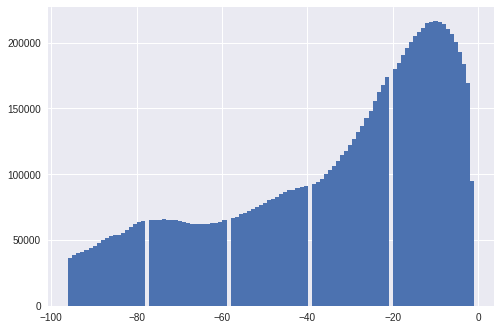

In [14]:
pos_bal['MONTHS_BALANCE'].hist(bins=100)

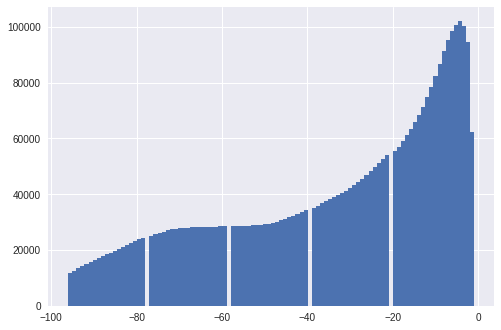

In [15]:
card_bal['MONTHS_BALANCE'].hist(bins=100)

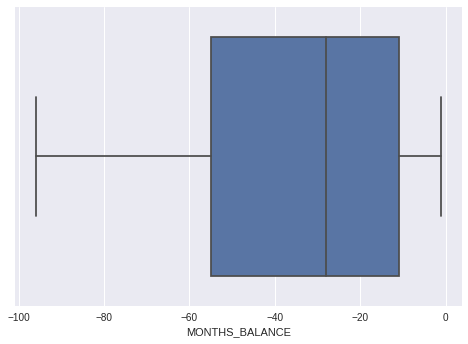

In [16]:
sns.boxplot(card_bal['MONTHS_BALANCE'])

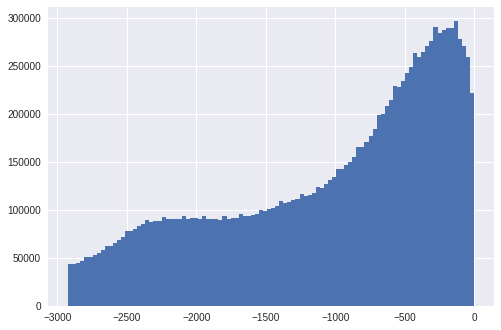

In [17]:
# 대출 월 납입예정일 (대출 신청 날짜 대비) 분포
install['DAYS_INSTALMENT'].hist(bins=100)

BALANCE 데이터 세트에 대한 컬럼 및 Null 조사
* POS_CACHE, INSTALL은 Null값이 많지 않지만, CREDIT_CARD의 경우 인출(DRAWINGS)관련 속성들의 Null값이 많음

In [18]:
pos_bal.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [19]:
install.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [20]:
card_bal.isnull().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

# 연속형 feature 시각화

## POS_CASH 연속형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [23]:
# TARGET 값 조인
pos_bal_app = pos_bal.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
pos_num_columns = pos_bal_app.dtypes[pos_bal_app.dtypes != 'object'].index.tolist()

# 연속형 컬럼 중 SK_ID_CURR, SK_ID_PREV, TARGET drop
pos_num_columns = [column for column in pos_num_columns if column not in ['SK_ID_CURR', 'SK_ID_PREV','TARGET']]

In [29]:
def show_hist_by_target(df, columns):
  cond_1 = (df['TARGET'] == 1)
  cond_0 = (df['TARGET'] == 0)

  for column in columns:
    plt.figure(figsize=(12,4))

    sns.distplot(df[cond_0][column], label='0', color='blue')
    sns.distplot(df[cond_1][column], label='1', color='red')  

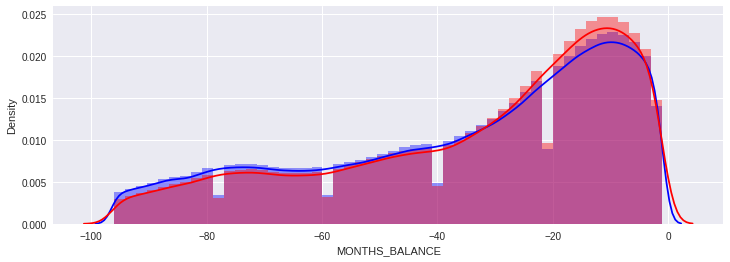

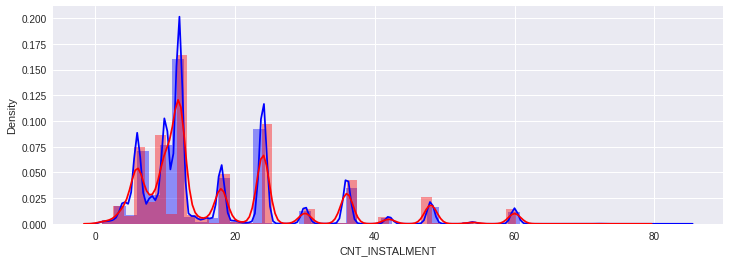

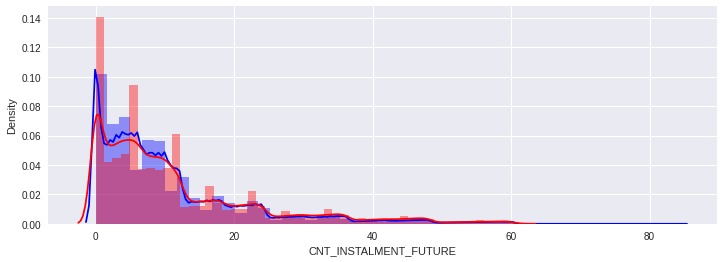

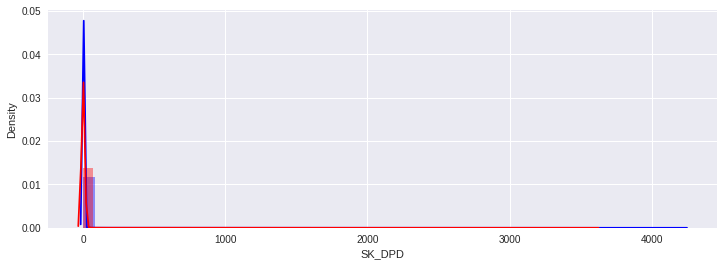

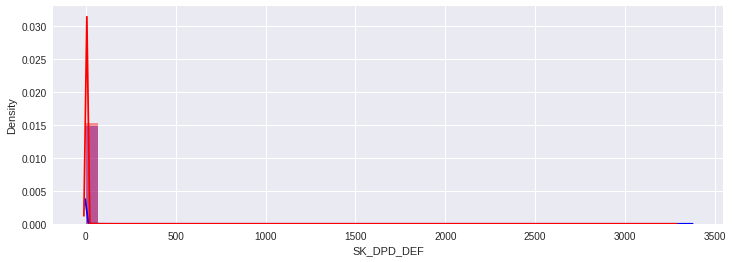

In [30]:
show_hist_by_target(pos_bal_app, pos_num_columns)

## INSTALLMENTS 연속형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [31]:
# TARGET 값 조인
install_app = install.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
install_num_columns = install_app.dtypes[install_app.dtypes != 'object'].index.tolist()

install_num_columns = [column for column in install_num_columns if column not in ['SK_ID_CURR', 'SK_ID_PREV', 'TARGET']]

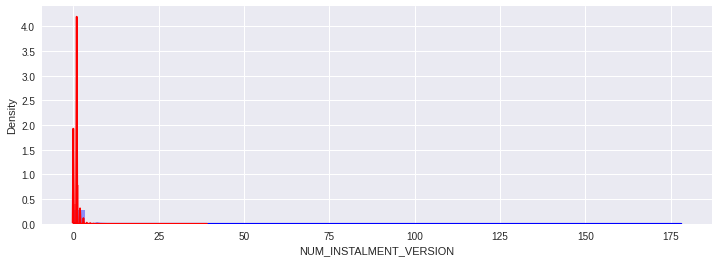

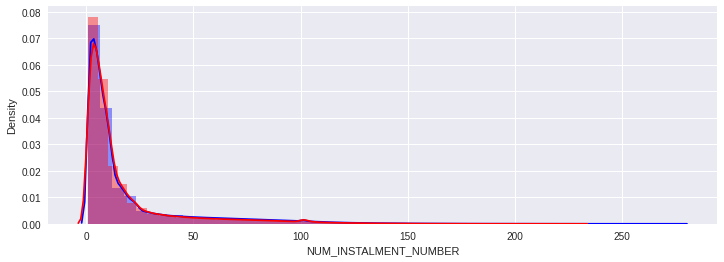

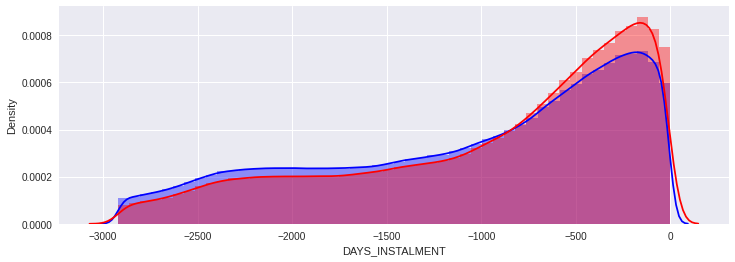

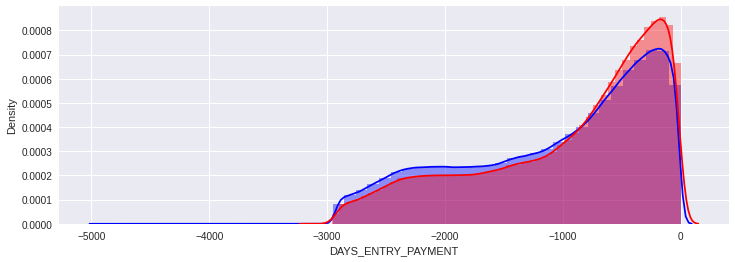

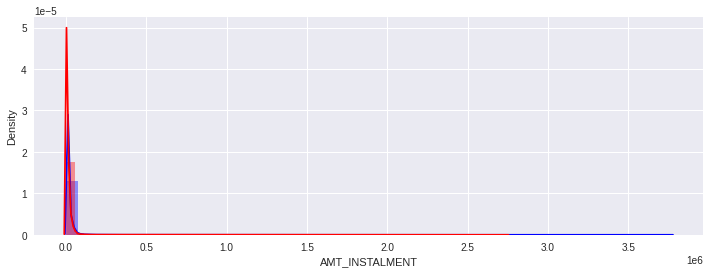

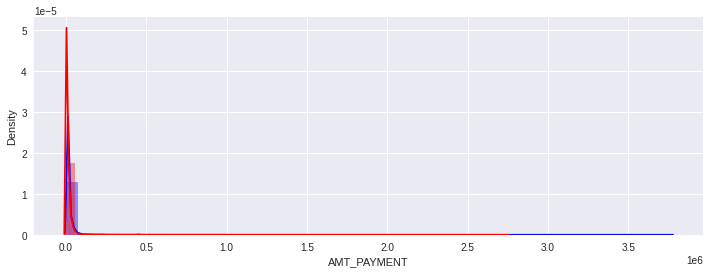

In [32]:
show_hist_by_target(install_app, install_num_columns)

## CREDIT_CARD 연속형 피처들의 Histogram을 TARGET 유형에 따라 비교

In [33]:
# TARGET 값 조인 
card_bal_app = card_bal.merge(apps[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
card_num_columns = card_bal_app.dtypes[card_bal_app.dtypes != 'object'].index.tolist()

card_num_columns = [column for column in card_num_columns if column not in['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]

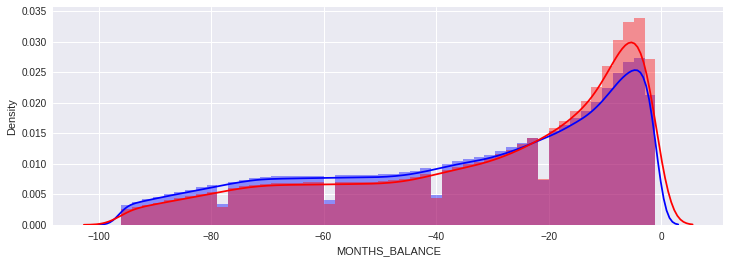

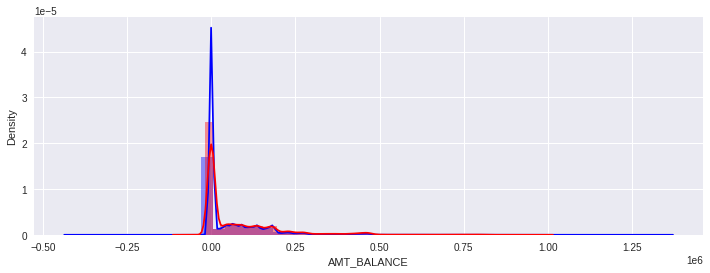

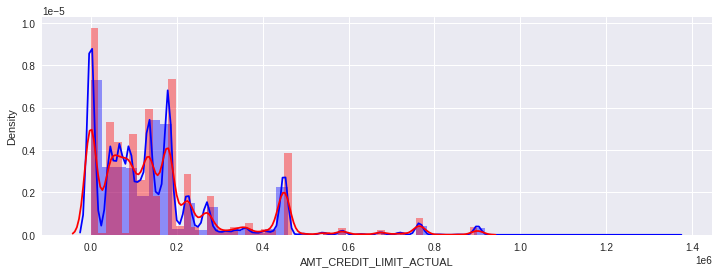

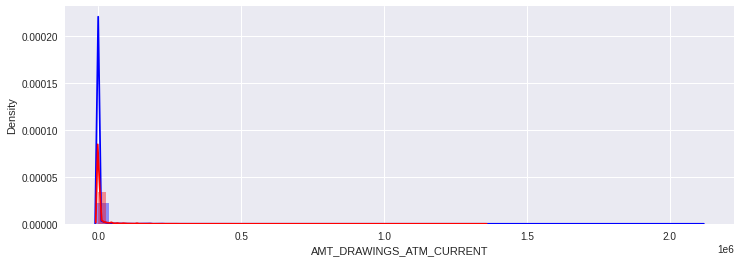

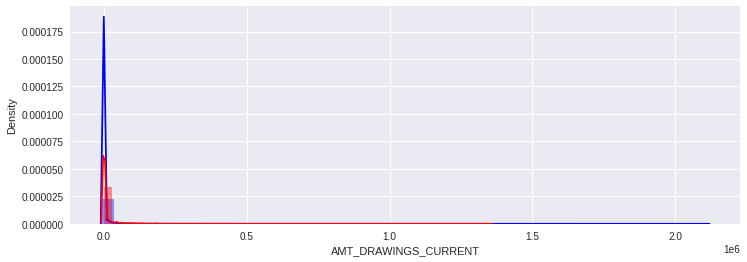

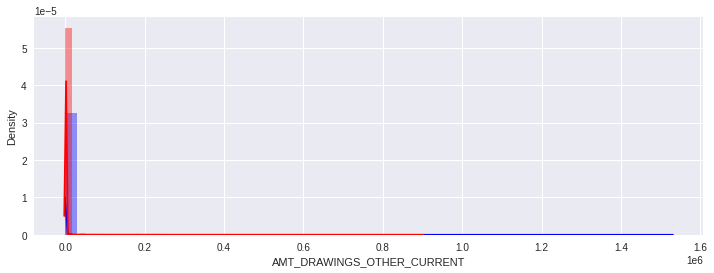

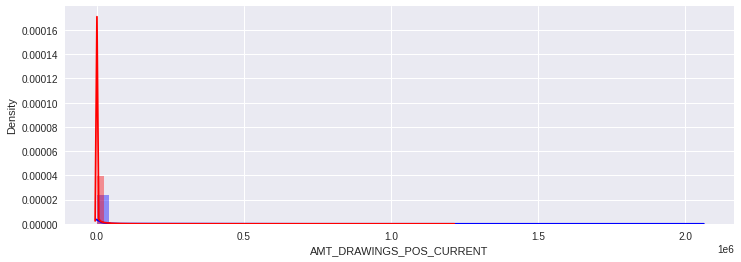

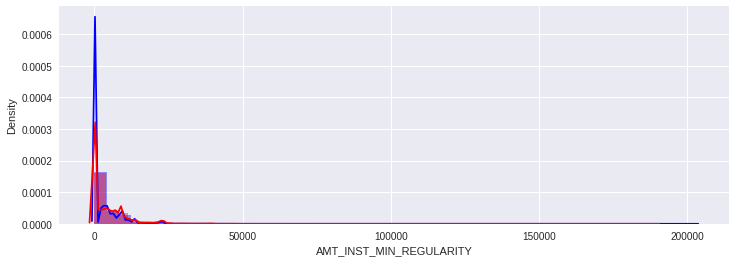

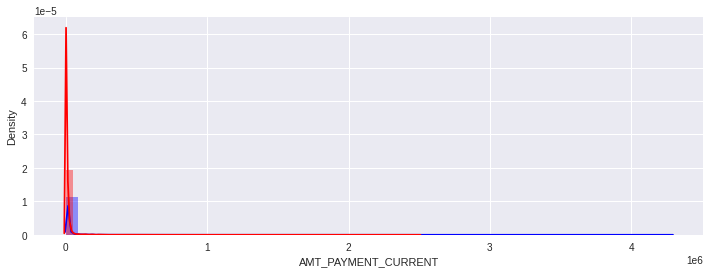

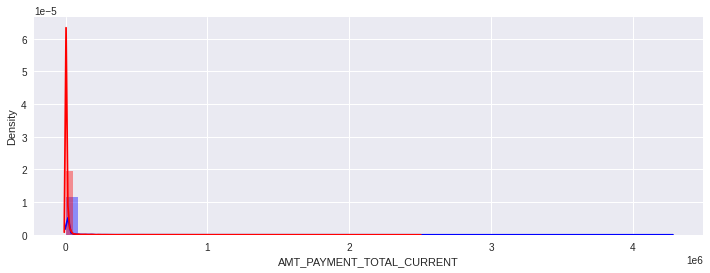

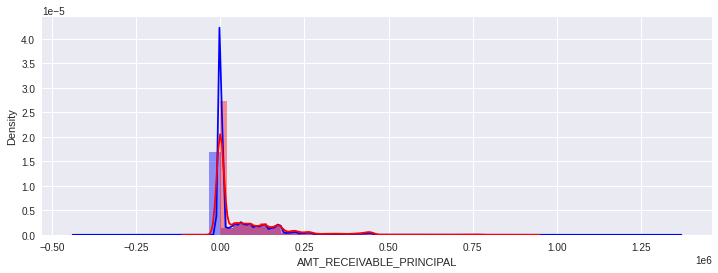

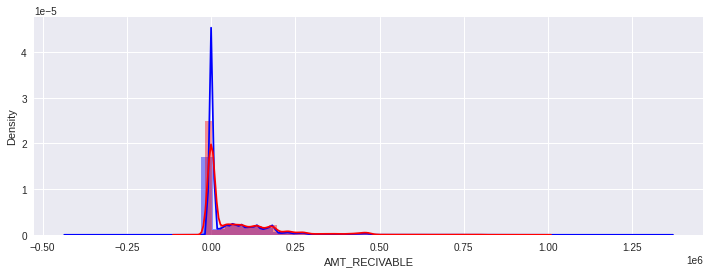

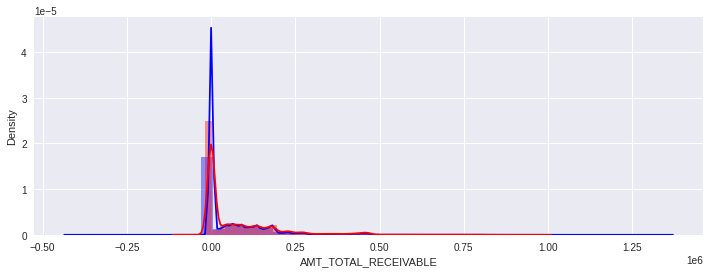

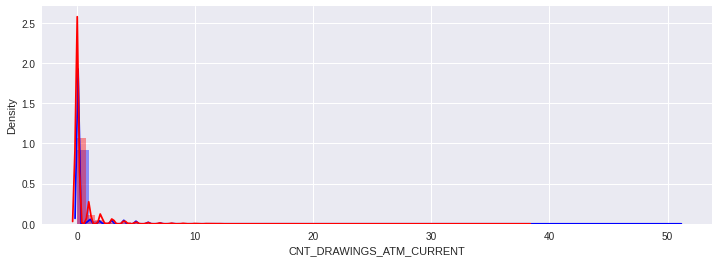

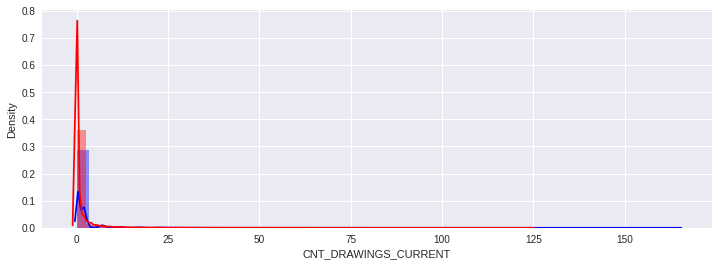

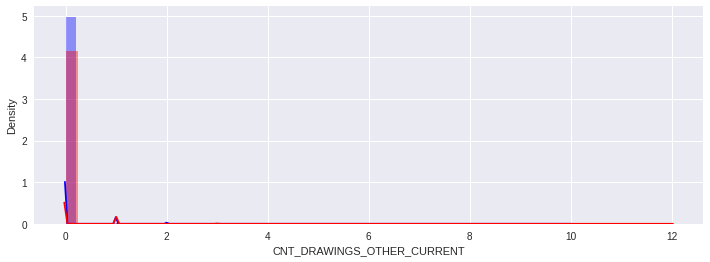

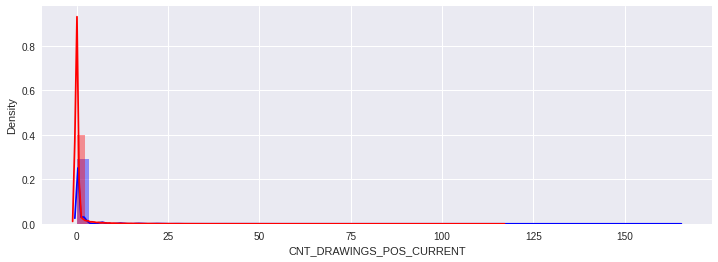

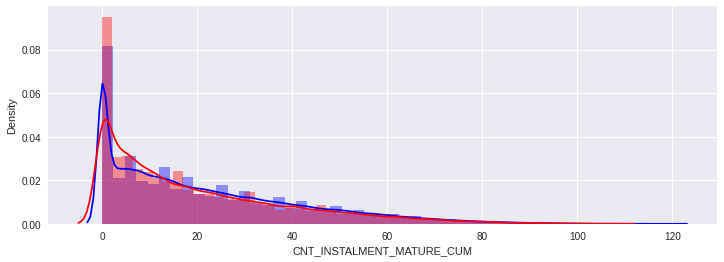

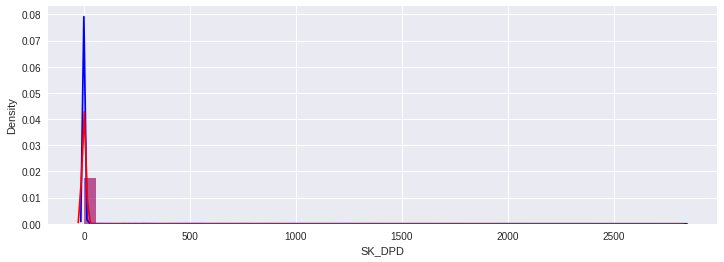

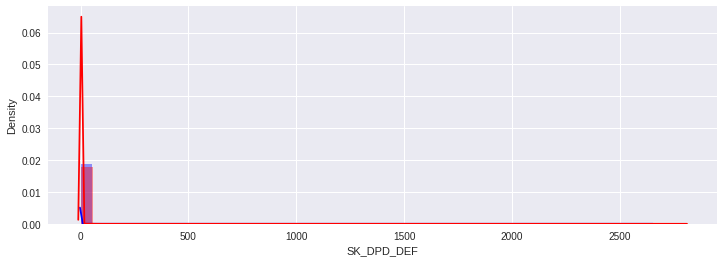

In [34]:
show_hist_by_target(card_bal_app, card_num_columns)

# 카테고리형 feature 분포도 

In [35]:
pos_bal['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [36]:
card_bal['NAME_CONTRACT_STATUS'].value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

### POS_CASH_balance  Feature Engineering

연체일자(SK_DPD)에 따른 FE

In [37]:
pos_bal['SK_DPD'].value_counts()

0       9706131
1         21872
2         17358
3         14403
4         12350
         ...   
3278          1
3280          1
3282          1
3284          1
4231          1
Name: SK_DPD, Length: 3400, dtype: int64

In [38]:
cond_over_0 = pos_bal['SK_DPD'] > 0
cond_over_0_30 = (pos_bal['SK_DPD'] > 0) & (pos_bal['SK_DPD'] <=30)
cond_over_30_12= (pos_bal['SK_DPD'] > 30) & (pos_bal['SK_DPD'] <120)
cond_over_120 = pos_bal['SK_DPD'] >= 120

print('연체 비율:', pos_bal[cond_over_0].shape[0]/ pos_bal.shape[0])
print('연체 비율 30일 미만, :', pos_bal[cond_over_0_30].shape[0]/ pos_bal.shape[0])
print('연체 비율 30일 이상 120이하:', pos_bal[cond_over_30_12].shape[0]/ pos_bal.shape[0])
print('연체 비율 120일 이상:', pos_bal[cond_over_120].shape[0]/ pos_bal.shape[0])

연체 비율: 0.02951869136171308
연체 비율 30일 미만, : 0.01631468446584954
연체 비율 30일 이상 120이하: 0.0017282653015720465
연체 비율 120일 이상: 0.011475741594291496


In [39]:
# 연체 여부
pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x>0 else 0)

# 연체일수 0일 이상, 120일 미만 여부
pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x: 1 if (x>0) & (x <120) else 0)

# 연체일수 120일 이상 여부
pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x>= 120 else 0)

기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨의 신규 aggregation 컬럼 생성

In [41]:
pos_bal_grp = pos_bal.groupby('SK_ID_CURR')

pos_bal_agg_dict = {
    'SK_ID_CURR':['count'], 
    'MONTHS_BALANCE':['min', 'mean', 'max'], 
    'SK_DPD':['min', 'max', 'mean'],

    'POS_IS_DPD':['mean', 'sum'],
    'POS_IS_DPD_UNDER_120':['mean', 'sum'],
    'POS_IS_DPD_OVER_120':['mean', 'sum']
}

pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

# 컬럼명 변경
pos_bal_agg.columns = [('POS_') + ('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]

In [42]:
pos_bal_agg.head()

,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM
SK_ID_CURR,,,,,,,,,,,,,
100001,9,-96,-72.555556,-53,0,7,0.777778,0.111111,1,0.111111,1,0.0,0
100002,19,-19,-10.000000,-1,0,0,0.000000,0.000000,0,0.000000,0,0.0,0
100003,28,-77,-43.785714,-18,0,0,0.000000,0.000000,0,0.000000,0,0.0,0
100004,4,-27,-25.500000,-24,0,0,0.000000,0.000000,0,0.000000,0,0.0,0
100005,11,-25,-20.000000,-15,0,0,0.000000,0.000000,0,0.000000,0,0.0,0


POS_CASH_BALANCE에서 MONTHS_BALANCE의 비교적 최근 데이터만 별도로 가공

In [43]:
cond_months = pos_bal['MONTHS_BALANCE'] > -20
pos_bal[cond_months].groupby('SK_ID_CURR')['SK_ID_CURR'].count()

SK_ID_CURR
100002    19
100003     2
100005     5
100006    20
100007    21
          ..
456248    18
456250    18
456251     9
456254    20
456255    47
Name: SK_ID_CURR, Length: 272296, dtype: int64

In [44]:
cond_months = pos_bal['MONTHS_BALANCE'] > -20

pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
pos_bal_agg_dict = {
    'SK_ID_CURR':['count'], 
    'MONTHS_BALANCE':['min', 'mean', 'max'], 
    'SK_DPD':['min', 'max', 'mean'],

    'POS_IS_DPD':['mean', 'sum'],
    'POS_IS_DPD_UNDER_120':['mean', 'sum'],
    'POS_IS_DPD_OVER_120':['mean', 'sum']
}

pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_agg_dict)

# 컬럼명 변경
pos_bal_m20_agg.columns = [('POS_M20') + ('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]

pos_bal_agg와 pos_bal_m20_agg를 조인

In [45]:
pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')

In [46]:
pos_bal_agg.head(3)

,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,POS_M20SK_ID_CURR_COUNT,POS_M20MONTHS_BALANCE_MIN,POS_M20MONTHS_BALANCE_MEAN,POS_M20MONTHS_BALANCE_MAX,POS_M20SK_DPD_MIN,POS_M20SK_DPD_MAX,POS_M20SK_DPD_MEAN,POS_M20POS_IS_DPD_MEAN,POS_M20POS_IS_DPD_SUM,POS_M20POS_IS_DPD_UNDER_120_MEAN,POS_M20POS_IS_DPD_UNDER_120_SUM,POS_M20POS_IS_DPD_OVER_120_MEAN,POS_M20POS_IS_DPD_OVER_120_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,9,-96,-72.555556,-53,0,7,0.777778,0.111111,1,0.111111,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,19,-19,-10.000000,-1,0,0,0.000000,0.000000,0,0.000000,0,0.0,0,19.0,-19.0,-10.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100003,28,-77,-43.785714,-18,0,0,0.000000,0.000000,0,0.000000,0,0.0,0,2.0,-19.0,-18.5,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
pos_bal_agg = pos_bal_agg.reset_index()
pos_bal_agg.head(3)

,SK_ID_CURR,POS_SK_ID_CURR_COUNT,POS_MONTHS_BALANCE_MIN,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_MAX,POS_SK_DPD_MIN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_POS_IS_DPD_MEAN,POS_POS_IS_DPD_SUM,POS_POS_IS_DPD_UNDER_120_MEAN,POS_POS_IS_DPD_UNDER_120_SUM,POS_POS_IS_DPD_OVER_120_MEAN,POS_POS_IS_DPD_OVER_120_SUM,POS_M20SK_ID_CURR_COUNT,POS_M20MONTHS_BALANCE_MIN,POS_M20MONTHS_BALANCE_MEAN,POS_M20MONTHS_BALANCE_MAX,POS_M20SK_DPD_MIN,POS_M20SK_DPD_MAX,POS_M20SK_DPD_MEAN,POS_M20POS_IS_DPD_MEAN,POS_M20POS_IS_DPD_SUM,POS_M20POS_IS_DPD_UNDER_120_MEAN,POS_M20POS_IS_DPD_UNDER_120_SUM,POS_M20POS_IS_DPD_OVER_120_MEAN,POS_M20POS_IS_DPD_OVER_120_SUM
0,100001,9,-96,-72.555556,-53,0,7,0.777778,0.111111,1,0.111111,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,19,-19,-10.000000,-1,0,0,0.000000,0.000000,0,0.000000,0,0.0,0,19.0,-19.0,-10.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,28,-77,-43.785714,-18,0,0,0.000000,0.000000,0,0.000000,0,0.0,0,2.0,-19.0,-18.5,-18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## installments_payments Feature Engineering

* 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 
* 예정 납부 일자 대비 실제 납부 일자 비교로  DPD 일자 생성 

In [48]:
# 예정 납부 금액과 실제 납부 금액 차이와 비율 가공
install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)

# 예정 납부 일자 대비 실제 납부 일자 비교로  DPD 일자 생성  
install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,AMT_DIFF,AMT_RATIO,SK_DPD
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,0.000000,1.000000,-7.0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0.000000,1.000000,0.0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0.000000,1.000000,0.0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,0.000000,1.000000,-8.0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,4.455078,0.997943,17.0


In [49]:
# 연체 일자(SK_DPD)에 따른 조건
cond_over_0 = install['SK_DPD'] > 0
cond_over_0_30 = (install['SK_DPD'] <= 30) & (install['SK_DPD'] > 0)
cond_over_30_120 = (install['SK_DPD'] < 120) & (install['SK_DPD'] > 30)
cond_over_120 = (install['SK_DPD'] >= 120)

print(' 연체 비율:', install[cond_over_0].shape[0]/install.shape[0] )
print(' 연체 비율 30일 미만:', install[cond_over_0_30].shape[0]/install.shape[0] )
print(' 연체일자 30일이상 120이하 비율 :', install[cond_over_30_120].shape[0]/install.shape[0] )
print(' 연체일자 120이상 비율 :', install[cond_over_120].shape[0]/install.shape[0] )

 연체 비율: 0.08428042657471103
 연체 비율 30일 미만: 0.08144023097885905
 연체일자 30일이상 120이하 비율 : 0.002042791682509027
 연체일자 120이상 비율 : 0.0007974039133429437


In [50]:
# 연체여부
install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

# 연체일수 0~ 120 사이 여부
install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )

# 연체 일수 120보다 큰 여부 
install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

In [51]:
install_grp = install.groupby('SK_ID_CURR')
install_agg_dict = {
    'SK_ID_CURR':['count'],
    'NUM_INSTALMENT_VERSION':['nunique'], 
    'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
    'DAYS_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_PAYMENT':['mean', 'max','sum'],

    'AMT_DIFF':['mean','min', 'max','sum'],
    'AMT_RATIO':['mean', 'max'],
    'SK_DPD':['mean', 'min', 'max'],
    'INS_IS_DPD':['mean', 'sum'],
    'INS_IS_DPD_UNDER_120':['mean', 'sum'],
    'INS_IS_DPD_OVER_120':['mean', 'sum']    
}

install_agg = install_grp.agg(install_agg_dict)

# 컬럼명 변경
install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]
install_agg.head()

,INS_SK_ID_CURR_COUNT,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_SUM,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_INSTALMENT_MAX,INS_DAYS_INSTALMENT_SUM,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_SUM,INS_AMT_DIFF_MEAN,INS_AMT_DIFF_MIN,INS_AMT_DIFF_MAX,INS_AMT_DIFF_SUM,INS_AMT_RATIO_MEAN,INS_AMT_RATIO_MAX,INS_SK_DPD_MEAN,INS_SK_DPD_MIN,INS_SK_DPD_MAX,INS_INS_IS_DPD_MEAN,INS_INS_IS_DPD_SUM,INS_INS_IS_DPD_UNDER_120_MEAN,INS_INS_IS_DPD_UNDER_120_SUM,INS_INS_IS_DPD_OVER_120_MEAN,INS_INS_IS_DPD_OVER_120_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,7,2,-2195.000000,-1628.0,-15365.0,-2187.714355,-1619.0,-15314.0,5885.132324,17397.900391,4.119593e+04,5885.132324,17397.900391,4.119593e+04,0.0,0.0,0.0,0.0,1.0,1.0,-7.285714,-36.0,11.0,0.142857,1,0.142857,1,0.0,0
100002,19,2,-315.421051,-49.0,-5993.0,-295.000000,-25.0,-5605.0,11559.247070,53093.746094,2.196257e+05,11559.247070,53093.746094,2.196257e+05,0.0,0.0,0.0,0.0,1.0,1.0,-20.421053,-31.0,-12.0,0.000000,0,0.000000,0,0.0,0
100003,25,2,-1385.319946,-544.0,-34633.0,-1378.160034,-536.0,-34454.0,64754.585938,560835.375000,1.618865e+06,64754.585938,560835.375000,1.618865e+06,0.0,0.0,0.0,0.0,1.0,1.0,-7.160000,-14.0,-1.0,0.000000,0,0.000000,0,0.0,0
100004,3,2,-761.666687,-727.0,-2285.0,-754.000000,-724.0,-2262.0,7096.154785,10573.964844,2.128846e+04,7096.154785,10573.964844,2.128846e+04,0.0,0.0,0.0,0.0,1.0,1.0,-7.666667,-11.0,-3.0,0.000000,0,0.000000,0,0.0,0
100005,9,2,-609.555542,-470.0,-5486.0,-586.000000,-466.0,-5274.0,6240.205078,17656.244141,5.616184e+04,6240.205078,17656.244141,5.616184e+04,0.0,0.0,0.0,0.0,1.0,1.0,-23.555555,-37.0,1.0,0.111111,1,0.111111,1,0.0,0


실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공

In [52]:
# DAYS_ENTRY_PAYMENT가 비교적 최근(1년 이내) 
cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365

install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
install_d365_agg_dict = {
    'SK_ID_CURR':['count'],
    'NUM_INSTALMENT_VERSION':['nunique'], 
    'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
    'DAYS_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_INSTALMENT':['mean', 'max', 'sum'],
    'AMT_PAYMENT':['mean', 'max','sum'],
    #  추가 컬럼
    'AMT_DIFF':['mean','min', 'max','sum'],
    'AMT_RATIO':['mean', 'max'],
    'SK_DPD':['mean', 'min', 'max'],
    'INS_IS_DPD':['mean', 'sum'],
    'INS_IS_DPD_UNDER_120':['mean', 'sum'],
    'INS_IS_DPD_OVER_120':['mean', 'sum']    
}
     
install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)

# 컬럼명 변경
install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]

install_agg과 새로 생성한 install_d365_agg 조인

In [53]:
install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
install_agg = install_agg.reset_index()

## credit_card_balance Feature Engineering

* 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
* DPD에 따른 가공

In [54]:
card_bal.isnull().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

In [55]:
# 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

연체일자에 따른 FE

In [56]:
cond_over_0 = card_bal['SK_DPD'] > 0
cond_over_0_30 = (card_bal['SK_DPD'] <= 30) & (card_bal['SK_DPD'] > 0)
cond_over_30_120 = (card_bal['SK_DPD'] < 120) & (card_bal['SK_DPD'] > 30)
cond_over_120 = (card_bal['SK_DPD'] >= 120)

print(' 연체 비율:', card_bal[cond_over_0].shape[0]/card_bal.shape[0] )
print(' 연체 비율 30일 미만:', card_bal[cond_over_0_30].shape[0]/card_bal.shape[0] )
print(' 연체일자 30일이상 120이하 비율 :', card_bal[cond_over_30_120].shape[0]/card_bal.shape[0] )
print(' 연체일자 120이상 비율 :', card_bal[cond_over_120].shape[0]/card_bal.shape[0] )

 연체 비율: 0.039932953364205825
 연체 비율 30일 미만: 0.025626303279525205
 연체일자 30일이상 120이하 비율 : 0.0022019044285985097
 연체일자 120이상 비율 : 0.01210474565608211


In [57]:
# 연체 여부
card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)

# 연체일수 0일 이상 120일 미만 여부
card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )

# 연체 일수 120일 이상 여부
card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

In [60]:
card_bal_grp = card_bal.groupby('SK_ID_CURR')
card_bal_agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_BALANCE':['max'],
    'AMT_CREDIT_LIMIT_ACTUAL':['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],

    'BALANCE_LIMIT_RATIO':['min','max'],
    'DRAWING_LIMIT_RATIO':['min', 'max'],
    'CARD_IS_DPD':['mean', 'sum'],
    'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
    'CARD_IS_DPD_OVER_120':['mean', 'sum']    
}

card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
# 컬럼명 변경
card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공

In [61]:
cond_month = card_bal['MONTHS_BALANCE'] >= -3
card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')

card_bal_agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_BALANCE':['max'],
    'AMT_CREDIT_LIMIT_ACTUAL':['max'],
    'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
    'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
    'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
    'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
    'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
    'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
    'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
    'CNT_DRAWINGS_POS_CURRENT': ['mean'],
    'SK_DPD': ['mean', 'max', 'sum'],

    'BALANCE_LIMIT_RATIO':['min','max'],
    'DRAWING_LIMIT_RATIO':['min', 'max'],
    'CARD_IS_DPD':['mean', 'sum'],
    'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
    'CARD_IS_DPD_OVER_120':['mean', 'sum']    
}

card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
# 컬럼명 변경
card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]

card_bal_agg와 새로 생성한 card_bal_m3_agg를 조인

In [62]:
card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
card_bal_agg = card_bal_agg.reset_index()

# application, previous, bureau, breau_bal 데이터 FE 함수

In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

def get_prev_processed(prev):
    # 대출 신청 금액과 실제 대출액/대출 상품금액 차이 및 비율
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    # prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
    
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # 첫번째 만기일과 마지막 만기일까지의 기간
    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
    # 매월 납부 금액과 납부 횟수 곱해서 전체 납부 금액 구함
    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    # 전체 납부 금액 대비 AMT_CREDIT 비율을 구하고 여기에 다시 납부횟수로 나누어서 이자율 계산
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']
        
    return prev
    
    
def get_prev_amt_agg(prev):
    # 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행
    agg_dict = {
         # 기존 컬럼 aggregation. 
        'SK_ID_CURR':['count'],
        'AMT_CREDIT':['mean', 'max', 'sum'],
        'AMT_ANNUITY':['mean', 'max', 'sum'], 
        'AMT_APPLICATION':['mean', 'max', 'sum'],
        'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
        'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        # 가공 컬럼 aggregation
        'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
        'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
        'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO':['mean', 'max'],
        'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
        'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)

    # multi index 컬럼을 '_'로 연결하여 컬럼명 변경
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]
    
    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    # 원래 groupby 컬럼 + 세부 기준 컬럼으로 groupby 수행. 세분화된 레벨로 aggregation 수행 한 뒤에 unstack()으로 컬럼레벨로 변형. 
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    # 컬럼명 변경. 
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    # NaN값은 모두 0으로 변경. 
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    
    return prev_refused_appr_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    
    # prev_amt_agg와 조인. 
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR별 과거 대출건수 대비 APPROVED_COUNT 및 REFUSED_COUNT 비율 생성. 
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' 컬럼 drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 컬럼 가공.
def get_bureau_processed(bureau):
    # 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
  
    # 채무 금액 대비/대출 금액 비율 및 차이 가공
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    #bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    # 연체 여부 및 120일 이상 연체 여부 가공
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

# bureau 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성. 
def get_bureau_day_amt_agg(bureau):
        
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],
    # 추가 가공 컬럼
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

# Bureau의 CREDIT_ACTIVE='Active' 인 데이터만 filtering 후 주요 컬럼 및 앞에서 채무 및 대출금액 관련 컬럼들로 SK_ID_CURR 레벨의 aggregation 컬럼 생성
def get_bureau_active_agg(bureau):
    # CREDIT_ACTIVE='Active' 인 데이터만 filtering
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
        'SK_ID_BUREAU':['count'],
        'DAYS_CREDIT':['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
        'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        # 추가 가공 컬럼
        'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
        'BUREAU_IS_DPD':['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120':['mean', 'sum']
        }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_active_agg = bureau_active_agg.reset_index()
    #print('bureau_active_agg shape:', bureau_active_agg.shape)
    return bureau_active_agg

# bureau_bal을 SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
def get_bureau_bal_agg(bureau, bureau_bal):
    # SK_ID_CURR레벨로 Group by하기 위해 bureau에서 SK_ID_CURR 컬럼을 가져오는 조인 수행. 
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    
    # STATUS에 따라 월별 연체 여부 및 120일 이상 연체 여부 속성 가공. 
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')
    # SK_ID_CURR 레벨로 건수와 MONTHS_BALANCE의 aggregation 가공 
    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]
    # 조인을 위해 SK_ID_CURR을 reset_index()로 컬럼화 
    bureau_bal_agg = bureau_bal_agg.reset_index()
    #print('bureau_bal_agg shape:', bureau_bal_agg.shape)
    return bureau_bal_agg
    
# 가공된 bureau관련 aggregation 컬럼들을 모두 결합   
def get_bureau_agg(bureau, bureau_bal):
    
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    # bureau_day_amt_agg와 bureau_active_agg 조인.  
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    # STATUS가 ACTIVE IS_DPD RATIO관련 비율 재가공. 
    #bureau_agg['BUREAU_IS_DPD_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    #bureau_agg['BUREAU_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    # bureau_agg와 bureau_bal_agg 조인. 
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']
    #bureau_bal_agg['BUREAU_BAL_IS_DPD_OVER120_RATIO'] = bureau_bal_agg['BUREAU_BAL_BUREAU_BAL_IS_DPD_OVER120_SUM']/bureau_bal_agg['BUREAU_BAL_SK_ID_CURR_COUNT']

    #print('bureau_agg shape:', bureau_agg.shape)
    
    return bureau_agg

def get_pos_bal_agg(pos_bal):
    # 연체 일자(SK_DPD)가 0 보다 큰 경우, 0~ 100 사이, 100보다 큰 경우 조사 
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    # 연체여부,  연체일수 0~ 120 사이 여부, 연체 일수 120보다 큰 여부 
    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성
    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)
    # 컬럼명 변경 
    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    # MONTHS_BALANCE가 최근(20개월 이하)인 데이터 세트 별도 가공. 
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        # 추가 컬럼. 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)
    # 컬럼 변경 
    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    
    # SK_ID_CURR을 reset_index()를 이용하여 컬럼으로 변환
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

def get_install_agg(install):
    # 예정 납부 금액 대비 실제 납부 금액 관련 데이터 가공. 예정 납부 일자 대비 실제 납부 일자 비교를 DPD 일자 생성  
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    # 연체여부,  연체일수 30~ 120 사이 여부, 연체 일수 100보다 큰 여부 데이터 가공. 
    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 신규 컬럼으로 SK_ID_CURR 레벨로 신규 aggregation 컬럼 생성. 
    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    
    # 실제 납부 일자(DAYS_ENTRY_PAYMENT)가 비교적 최근(1년 이내) 데이터만 별도로 가공
    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],
        #  추가 컬럼
        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

def get_card_bal_agg(card_bal):
    # 월별 카드 허용한도에 따른 잔고와 인출 금액 비율 
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    # DPD에 따른 가공 컬럼 생성.
    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    # 기존 컬럼과 가공 컬럼으로 SK_ID_CURR 레벨로 aggregation 신규 컬럼 생성. 
    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
         #'MONTHS_BALANCE':['min', 'max', 'mean'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        #  추가 컬럼
        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    # MONTHS_BALANCE가 비교적 최근 데이터( 3개월 이하)만 별도로 가공.  
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg

def get_apps_all_with_prev_agg(apps, prev):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')

    return apps_all

def get_apps_all_encoded(apps_all):
    object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
    for column in object_columns:
        apps_all[column] = pd.factorize(apps_all[column])[0]
    
    return apps_all

def get_apps_all_train_test(apps_all):
    apps_all_train = apps_all[~apps_all['TARGET'].isnull()]

    apps_all_test = apps_all[apps_all['TARGET'].isnull()]
    apps_all_test = apps_all_test.drop('TARGET', axis=1)
    
    return apps_all_train, apps_all_test
    
def train_apps_all(apps_all_train):
    ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    target_app = apps_all_train['TARGET']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=2000,
                learning_rate=0.02,
                max_depth = 11,
                num_leaves=58,
                colsample_bytree=0.613,
                subsample=0.708,
                max_bin=407,
                reg_alpha=3.564,
                reg_lambda=4.930,
                min_child_weight= 6,
                min_child_samples=165,
                silent=-1,
                verbose=-1,
                )
   
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 200)
    
    return clf

FE 한 모든 데이터 조인

In [5]:
# apps와 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 개별 함수 호출하여 생성후 조인 결합
def get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal):
    apps_all =  get_apps_processed(apps)
    prev_agg = get_prev_agg(prev)
    bureau_agg = get_bureau_agg(bureau, bureau_bal)
    pos_bal_agg = get_pos_bal_agg(pos_bal)
    install_agg = get_install_agg(install)
    card_bal_agg = get_card_bal_agg(card_bal)
    
    # 생성된 prev_agg, bureau_agg, pos_bal_agg, install_agg, card_bal_agg를 apps와 조인하여 최종 학습/테스트 집합 생성. 
    apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(bureau_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(pos_bal_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(install_agg, on='SK_ID_CURR', how='left')
    apps_all = apps_all.merge(card_bal_agg, on='SK_ID_CURR', how='left')
    
    return apps_all

데이터 로드 함수

In [6]:
def get_dataset():
    app_train = pd.read_csv(os.path.join(path,'application_train.csv'))
    app_test = pd.read_csv(os.path.join(path,'application_test.csv'))
    apps = pd.concat([app_train, app_test])
    
    prev = pd.read_csv(os.path.join(path,'previous_application.csv'))
    bureau = pd.read_csv(os.path.join(path,'bureau.csv'))
    bureau_bal = pd.read_csv(os.path.join(path,'bureau_balance.csv'))
    
    pos_bal, install, card_bal = get_balance_data()
        
    return apps, prev, bureau, bureau_bal, pos_bal, install, card_bal

# 모든 데이터 가공, 인코딩, 학습 수행

In [7]:
apps, prev, bureau, bureau_bal, pos_bal, install, card_bal = get_dataset()

In [10]:
# application, previous, bureau, bureau_bal 관련 데이터셋 가공 및 취합
apps_all = get_apps_all_with_all_agg(apps, prev, bureau, bureau_bal, pos_bal, install, card_bal)

# Category 컬럼을 모두 Label 인코딩 수행. 
apps_all = get_apps_all_encoded(apps_all)

# 학습과 테스트 데이터로 분리. 
apps_all_train, apps_all_test = get_apps_all_train_test(apps_all)

#학습수행. 
clf = train_apps_all(apps_all_train)

train shape: (215257, 447) valid shape: (92254, 447)
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_logloss: 0.238681	training's auc: 0.79644	valid_1's binary_logloss: 0.244924	valid_1's auc: 0.770142
[200]	training's binary_logloss: 0.22709	training's auc: 0.820548	valid_1's binary_logloss: 0.23906	valid_1's auc: 0.782028
[300]	training's binary_logloss: 0.219501	training's auc: 0.837474	valid_1's binary_logloss: 0.236772	valid_1's auc: 0.78755
[400]	training's binary_logloss: 0.213403	training's auc: 0.851446	valid_1's binary_logloss: 0.235674	valid_1's auc: 0.790328
[500]	training's binary_logloss: 0.208022	training's auc: 0.863648	valid_1's binary_logloss: 0.235024	valid_1's auc: 0.792074
[600]	training's binary_logloss: 0.203124	training's auc: 0.874653	valid_1's binary_logloss: 0.234607	valid_1's auc: 0.793234
[700]	training's binary_logloss: 0.19862	training's auc: 0.884445	valid_1's binary_logloss: 0.234402	valid_1's auc: 0.793745
[800]	t

In [11]:
preds = clf.predict_proba(apps_all_test.drop(['SK_ID_CURR'], axis=1))[:, 1]
apps_all_test['TARGET'] = preds

apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(path, 'BALANCE_baseline_01.csv'), index=False)